### Fixed Horizon Methods

In finance, almost all machine learning papers label observations using fixed horizon methods. This technique can be described as follows. Consider a feature matrix $X$ containing $I$ rows extracted from bars indexed by $t = 1, \ldots, T$ (where $I \leq T$). As discussed in the last part of Chapter 2, we have a sampling technique to generate the feature set $\{x_i\}_{i=1}^{I}$. Each observation $X_i$ is assigned a label $y_i \in \{-1, 0, 1\}$ based on the following criteria:

$$
y_i=
\begin{cases}
-1 & \text{if } r_{t_{i,0}, t_{i,0}+h} < -\tau\\
0 & \text{if } |r_{t_{i,0}, t_{i,0}+h}| \leq \tau\\
1 & \text{if } r_{t_{i,0}, t_{i,0}+h} > \tau
\end{cases}
$$

Here, $\tau$ is a predefined constant threshold, $t_{i,0}$ represents the bar index immediately after which $X_i$ occurs, $t_{i,0} + h$ is the bar index $h$ periods after $t_{i,0}$, and $r_{t_{i,0}, t_{i,0}+h}$ is the price return over the bar period $h$:

$$r_{t_{i,0}, t_{i,0}+h} = \frac{p_{t_{i,0}+h}}{p_{t_{i,0}}} - 1$$

This structured approach allows for systematic labeling of observations, which can be utilized in various machine learning algorithms for financial forecasting and decision-making.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_date = '2000-01-01'
end_date = '2024-04-27'
ticker = '^GSPC'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


In [4]:
ret = data['Close'].pct_change(fill_method = None).dropna()

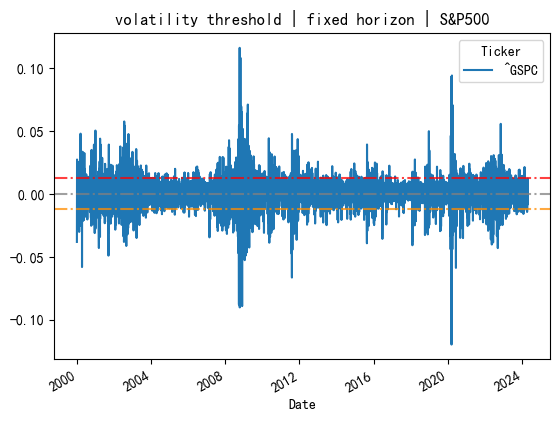

In [8]:
ret.plot(grid = False)
plt.axhline(y = ret.std().loc[ticker], color = 'red', linestyle = '-.', alpha = 0.75)
plt.axhline(y = 0, color = 'gray', linestyle = '-.', alpha = 0.75)
plt.axhline(y = -ret.std().loc[ticker], color = 'darkorange', linestyle = '-.', alpha = 0.75)
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()

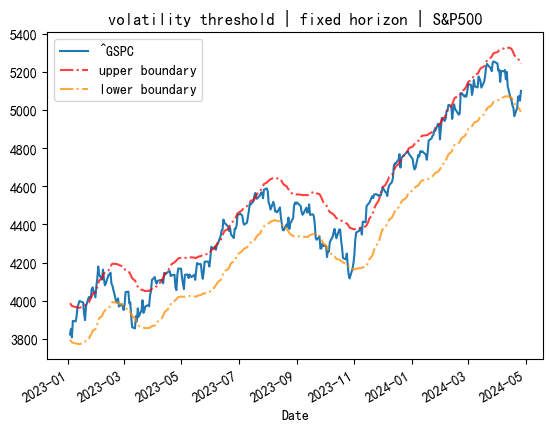

In [9]:
data['Close']['2023':].plot(grid = False, label = 'prices')
plt.plot(
    data['Close'].rolling(window = 20).mean()['2023':] + ret.std().loc[ticker] * data['Close'].rolling(window = 20).mean()['2023':] * 2, 
    color = 'red', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'upper boundary'
)
plt.plot(
    data['Close'].rolling(window = 20).mean()['2023':] - ret.std().loc[ticker] * data['Close'].rolling(window = 20).mean()['2023':] * 2, 
    color = 'darkorange', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'lower boundary'
)
plt.legend()
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()

Papers often utilize time bars, so \(h\) signifies a fixed period. Several machine learning studies, including one by Dixon (2016), illustrate this labeling technique. Despite its recognition, there are compelling reasons to avoid this method:

1. As discussed in Chapter 2, time bars do not exhibit good statistical properties.
2. A constant threshold $\tau$ is applied regardless of observed volatility. For instance, assuming $\tau = 0.01$, labeling could yield $y_i = 1$ at times when the realized volatility is $\sigma_{t_{i,0}} = 0.0001$ or $\sigma_{t_{i,0}} = 0.01$. Even if the return $r_{t_{i,0}, t_{i,0}+h}$ is predictable and statistically significant, most labels may default to 0.

In other words, labeling observations based on a fixed threshold from time bars is a prevalent error. Better alternatives include:

1. Labeling based on a threshold $\sigma_{i,0}$ that varies according to the exponentially weighted moving average of the standard deviation calculated over a rolling window of returns.
2. Utilizing volume bars or dollar bars, which tend to have more consistent volatility.

However, these two improvements do not address the fundamental flaw of fixed period methods since price paths are followed. In all investment strategies, whether determined by portfolio managers or enforced by risk departments or margin calls, there are stop-loss limits. Developing strategies that generate profits from positions stopped out in trades is unrealistic. The lack of literature considering this aspect when labeling observations reflects the current state of academic research related to investments.

### Computing Dynamic Thresholds

As discussed earlier, to effectively set profit-taking and stop-loss thresholds, it's essential to account for the inherent risk in betting. Without this consideration, you might end up wanting unrealistically high returns when the current volatility is low ($\tau > \sigma_{t_{i,0}}$) or unreasonably low returns when the volatility is high ($\tau < \sigma_{t_{i,0}}$).

The following code snippet applies an exponentially weighted moving average (EWMA) deviation to calculate daily volatility at a given estimation point over a specified `lookback` period. If you want to learn more about the `pandas.Series.ewm` function, refer to the pandas documentation.

```python
import pandas as pd

# Assuming `returns` is a pandas Series of daily returns
lookback = 20  # Number of periods for lookback
daily_volatility = returns.ewm(span=lookback).std()

# Optionally, you can create thresholds for profit taking and stop loss
tau = 0.01  # Example threshold
profit_take_threshold = daily_volatility + tau
stop_loss_threshold = daily_volatility - tau

# Example of how to use the thresholds
# This is a placeholder logic; you would adapt it to your strategy
for i in range(len(returns)):
    if returns[i] >= profit_take_threshold[i]:
        print(f"Take profit at index {i}")
    elif returns[i] <= stop_loss_threshold[i]:
        print(f"Stop loss at index {i}")
```

This code calculates the daily volatility based on a specified lookback period and sets profit-taking and stop-loss thresholds based on that volatility. Adjust the logic according to your specific trading strategy.

In [10]:
from quant_free.finml.features.volatility import daily_volatility

volatility = daily_volatility(data['Close'], lookback = 60)

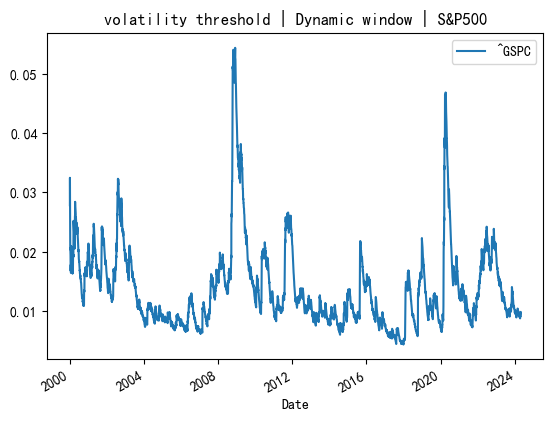

In [11]:
volatility.plot(grid = False, label = 'EWMA volatility')
plt.title('volatility threshold | Dynamic window | S&P500')
plt.legend()
plt.show()

You can use the output of this function to establish default profit-taking and stop-loss values for the remainder of Chapter 3. By integrating the calculated daily volatility into your strategy, you can define these thresholds in a way that reflects the current market conditions. 

For example, you might set your profit-taking and stop-loss limits as a multiple of the computed daily volatility:

1. **Profit-Taking Threshold**: You could set this to a certain factor above the average daily volatility, allowing you to capture gains without being overly aggressive.
  
2. **Stop-Loss Threshold**: Similarly, this could be a certain factor below the average daily volatility, ensuring that you limit losses in a systematic way.

Using the daily volatility outputs, your implementation might look like this:

```python
# Example multipliers for thresholds
profit_multiplier = 1.5
loss_multiplier = 1.0

# Setting default profit-taking and stop-loss values
default_profit_take = daily_volatility * profit_multiplier
default_stop_loss = daily_volatility * loss_multiplier

# Apply the thresholds to your trading strategy as needed
for i in range(len(returns)):
    if returns[i] >= default_profit_take[i]:
        print(f"Default Take Profit at index {i}")
    elif returns[i] <= default_stop_loss[i]:
        print(f"Default Stop Loss at index {i}")
```

By utilizing this approach, you can dynamically adjust your thresholds based on market volatility, improving the robustness of your trading strategy as discussed in Chapter 3.

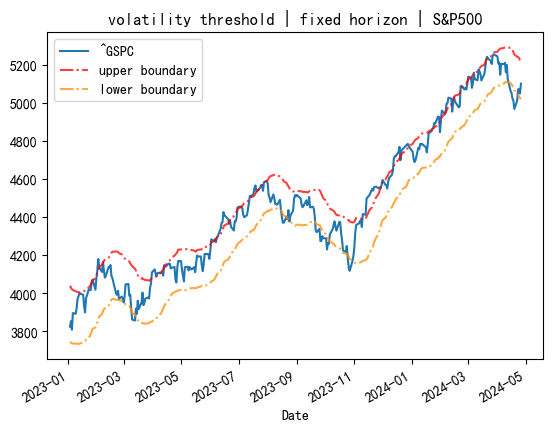

In [12]:
data['Close']['2023':].plot(grid = False, label = 'prices')
plt.plot(
    (data['Close'].rolling(20).mean()['2023':] + data['Close'].rolling(20).mean()['2023':] * volatility['2023':] * 2), 
    color = 'red', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'upper boundary'
)
plt.plot(
    (data['Close'].rolling(20).mean()['2023':] - data['Close'].rolling(20).mean()['2023':] * volatility['2023':] * 2), 
    color = 'darkorange', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'lower boundary'
)
plt.legend()
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()